<a href="https://colab.research.google.com/github/aaditi72/Stock_Prediction/blob/main/Stock%20Market%20Forecasting%20Using%20FB-Prohet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install Prophet

In [3]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize']=(16,8)
plt.style.use('ggplot')

In [7]:
!pip install yfinance
import yfinance as yf

data = yf.download('GOOG', start='2017-01-01')
data.to_csv('GOOG.csv')  # Save it as GOOG.csv
data.reset_index().to_csv('GOOG.csv', index=False)
prices_df = pd.read_csv('GOOG.csv', index_col='Date', parse_dates=True)


[*********************100%***********************]  1 of 1 completed


In [12]:
print(prices_df.index)


DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12',
               '2017-01-13', '2017-01-17',
               ...
               '2025-04-14', '2025-04-15', '2025-04-16', '2025-04-17',
               '2025-04-21', '2025-04-22', '2025-04-23', '2025-04-24',
               '2025-04-25',        'NaT'],
              dtype='datetime64[ns]', name='Date', length=2091, freq=None)


In [14]:
import yfinance as yf
import pandas as pd

# Download data
prices_df = yf.download('GOOG', start='2017-01-01')

# Keep only Close column
prices_df = prices_df[['Close']]

# Sort index
prices_df = prices_df.sort_index()

# Drop rows where index (Date) is NaT
prices_df = prices_df.dropna()

# Now safe to slice
prices_df = prices_df.loc['2017-01-01':, :]

# Reindex to daily frequency
idx = pd.date_range(prices_df.index.min(), prices_df.index.max(), freq='D')
prices_df = prices_df.reindex(idx)
prices_df = prices_df.rename_axis('Date')

# Train/test split
test_size = 100
data_train = prices_df.iloc[:-test_size, :]
data_test = prices_df.iloc[-test_size:, :]


[*********************100%***********************]  1 of 1 completed


In [15]:
prices_df

Price,Close
Ticker,GOOG
Date,
2017-01-03,39.121704
2017-01-04,39.159523
2017-01-05,39.513844
2017-01-06,40.117481
2017-01-07,NaN
...,...
2025-04-21,149.860001
2025-04-22,153.899994


In [16]:
data_train.describe()

Price,Close
Ticker,GOOG
count,2021.000000
mean,95.123939
std,41.753900
min,39.121704
25%,56.739750
50%,88.153961
75%,131.268250
max,197.934509


Price,ds,y
Ticker,,GOOG
2930,2025-01-11,NaN
2931,2025-01-12,NaN
2932,2025-01-13,192.071167
2933,2025-01-14,190.832596
2934,2025-01-15,196.755844


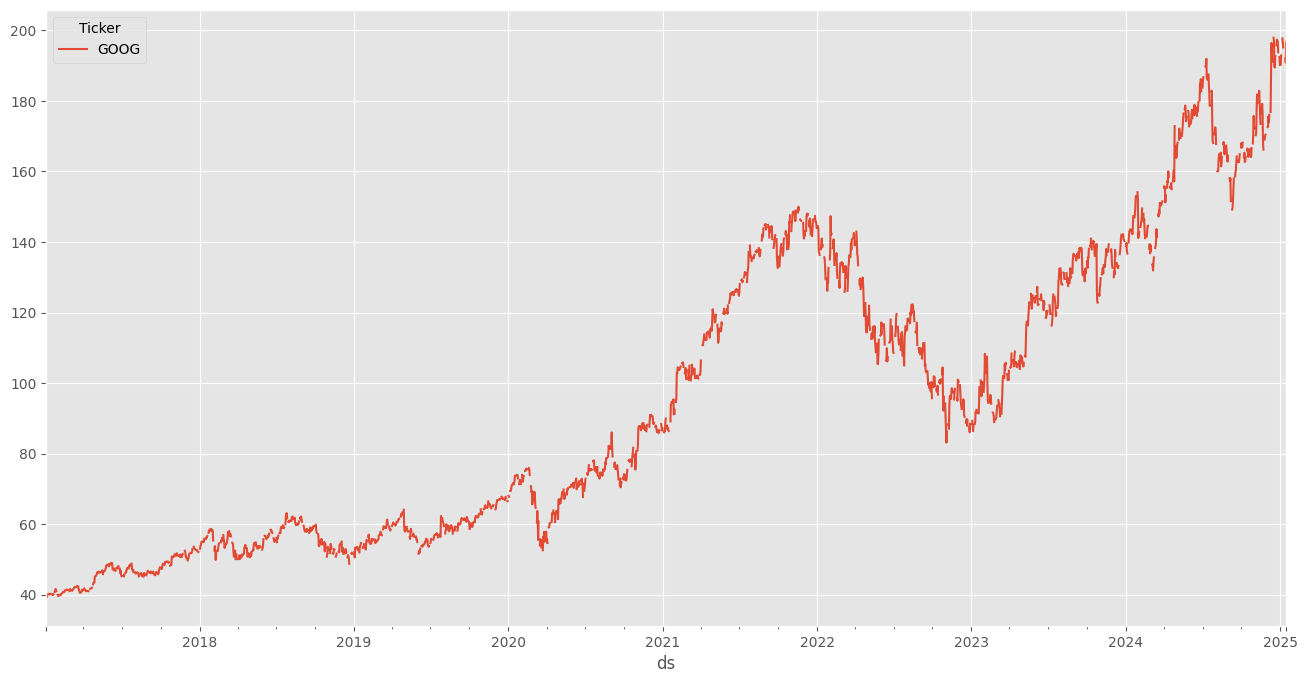

In [17]:
df = data_train.reset_index()
df=df.rename(columns={'Date':'ds', 'Close':'y'})
df['ds'] = pd.to_datetime(df['ds'])
df.set_index('ds').y.plot()
df.tail(5)

In [20]:
print(df.columns)
print(df.head())

MultiIndex([('ds',     ''),
            ( 'y', 'GOOG')],
           names=['Price', 'Ticker'])
Price          ds          y
Ticker                  GOOG
0      2017-01-03  39.121704
1      2017-01-04  39.159523
2      2017-01-05  39.513844
3      2017-01-06  40.117481
4      2017-01-07        NaN


In [21]:
# Flatten MultiIndex
df.columns = df.columns.get_level_values(0)

# Drop any rows with NaN values
df = df.dropna()

# Double-check types
df['ds'] = pd.to_datetime(df['ds'])
df['y'] = pd.to_numeric(df['y'])


<ipython-input-21-6133ef989f59>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ds'] = pd.to_datetime(df['ds'])
<ipython-input-21-6133ef989f59>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y'] = pd.to_numeric(df['y'])


In [22]:
model = Prophet(daily_seasonality=True)
model.fit(df)

print("✅ Model trained successfully!")

DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7cdz7q6/300yr13y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7cdz7q6/r6_9alem.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91250', 'data', 'file=/tmp/tmpv7cdz7q6/300yr13y.json', 'init=/tmp/tmpv7cdz7q6/r6_9alem.json', 'output', 'file=/tmp/tmpv7cdz7q6/prophet_modeldopk7iah/prophet_model-20250428083949.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:39:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:39:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Model trained successfully!


In [23]:
future = model.make_future_dataframe(periods= int((data_test.index[-1] - data_train.index[-1]).days),freq = 'd')
future.tail(14)

,ds
2176,2025-07-21
2177,2025-07-22
2178,2025-07-23
2179,2025-07-24
2180,2025-07-25
2181,2025-07-26
2182,2025-07-27
2183,2025-07-28
2184,2025-07-29
2185,2025-07-30


In [24]:
# Eliminate weekend from future dataframe
future['day'] = future['ds'].dt.weekday
future = future[(future['day']<5)]
future.tail(14)

,ds,day
2170,2025-07-15,1
2171,2025-07-16,2
2172,2025-07-17,3
2173,2025-07-18,4
2176,2025-07-21,0
2177,2025-07-22,1
2178,2025-07-23,2
2179,2025-07-24,3
2180,2025-07-25,4
2183,2025-07-28,0


In [25]:
forecast = model.predict(future)

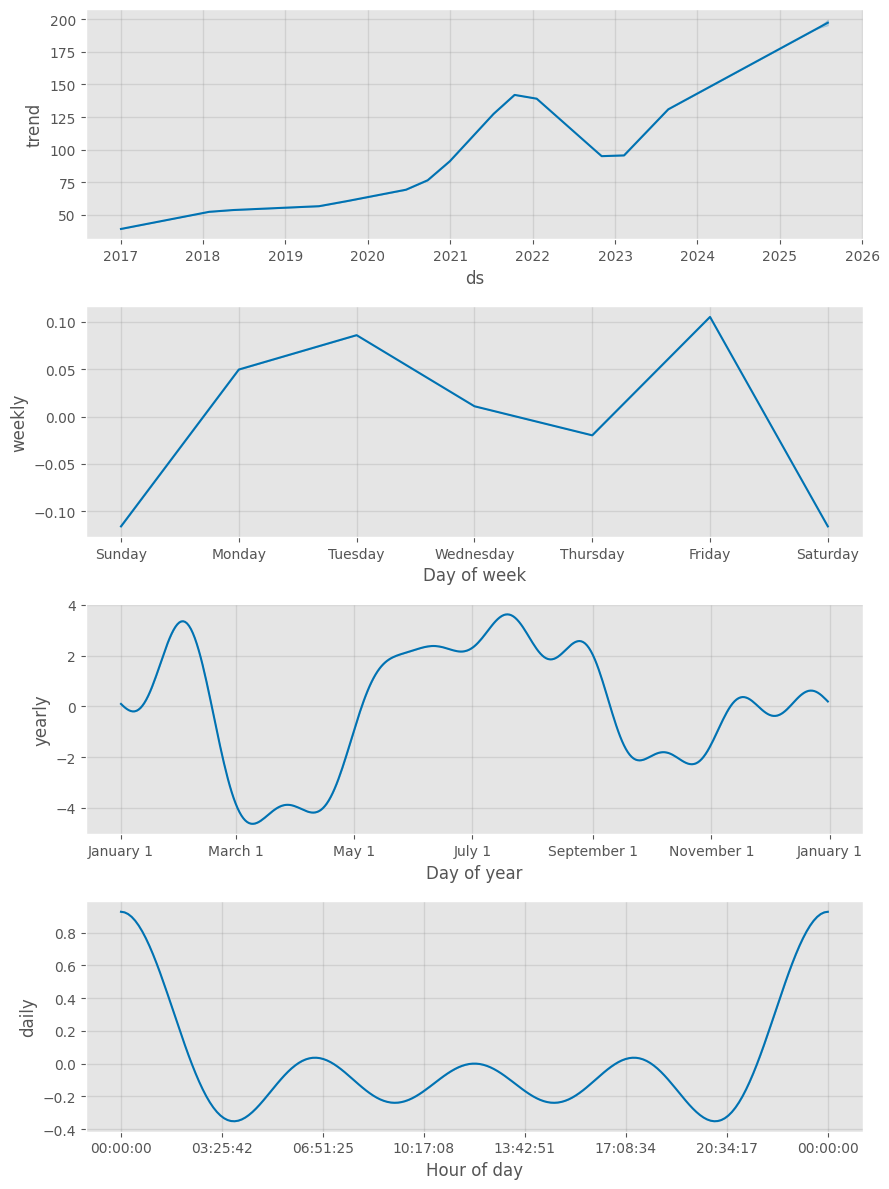

In [26]:
fig = model.plot_components(forecast)

In [27]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2017-01-03,40.165935,31.425062,48.923356
1,2017-01-04,40.066279,31.728345,48.567839
2,2017-01-05,40.022785,31.681423,47.953237
3,2017-01-06,40.149364,31.351041,48.664282
4,2017-01-09,40.204447,31.941279,48.774628
...,...,...,...,...
2155,2025-07-28,200.975375,192.496306,209.257350
2156,2025-07-29,200.982566,192.006461,210.244050
2157,2025-07-30,200.875357,192.275269,209.815478
2158,2025-07-31,200.812182,192.547322,210.296649


In [30]:
# Flatten the columns for prices_df (remove multi-level index)
prices_df.columns = prices_df.columns.get_level_values(0)

# Reset index on both DataFrames (to avoid index conflicts)
prices_df = prices_df.reset_index()
new_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].reset_index()

# Merge the data on 'Date' and 'ds' (matching the common column)
viz_df = prices_df.set_index('Date').join(new_forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']], how='outer')

# Optionally, view the merged data
print(viz_df.head())


            index      Close       yhat  yhat_lower  yhat_upper
2017-01-03    0.0  39.121704  40.165935   31.425062   48.923356
2017-01-04    1.0  39.159523  40.066279   31.728345   48.567839
2017-01-05    2.0  39.513844  40.022785   31.681423   47.953237
2017-01-06    3.0  40.117481  40.149364   31.351041   48.664282
2017-01-07    4.0        NaN        NaN         NaN         NaN


In [31]:
viz_df

,index,Close,yhat,yhat_lower,yhat_upper
2017-01-03,0.0,39.121704,40.165935,31.425062,48.923356
2017-01-04,1.0,39.159523,40.066279,31.728345,48.567839
2017-01-05,2.0,39.513844,40.022785,31.681423,47.953237
2017-01-06,3.0,40.117481,40.149364,31.351041,48.664282
2017-01-07,4.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2025-07-28,NaN,NaN,200.975375,192.496306,209.257350
2025-07-29,NaN,NaN,200.982566,192.006461,210.244050
2025-07-30,NaN,NaN,200.875357,192.275269,209.815478
2025-07-31,NaN,NaN,200.812182,192.547322,210.296649


In [32]:
prices_df.index = pd.to_datetime(prices_df.index) #make sure our index as a datetime object
connect_date = data_train.index[-2] #select the 2nd to last date
connect_date

Timestamp('2025-01-14 00:00:00')

In [35]:
# Ensure that 'ds' column is converted to datetime (if it's not already)
new_forecast['ds'] = pd.to_datetime(new_forecast['ds'])

# Set the datetime column 'ds' as the index
new_forecast.set_index('ds', inplace=True)

# Now apply the mask
mask = new_forecast.index > pd.to_datetime(connect_date)

# Apply the mask to get the subset of data
predict_df = new_forecast.loc[mask]

# Optionally, print the resulting DataFrame
print(predict_df.head())


            index        yhat  yhat_lower  yhat_upper
ds                                                   
2025-01-15   2020  180.125637  172.013312  188.905865
2025-01-16   2021  180.358260  171.832759  189.143621
2025-01-17   2022  180.763068  172.832200  189.574170
2025-01-21   2023  181.971775  173.153493  190.708009
2025-01-22   2024  182.214737  173.665783  191.064162


In [36]:
predict_df.head()

,index,yhat,yhat_lower,yhat_upper
ds,,,,
2025-01-15,2020,180.125637,172.013312,188.905865
2025-01-16,2021,180.358260,171.832759,189.143621
2025-01-17,2022,180.763068,172.832200,189.574170
2025-01-21,2023,181.971775,173.153493,190.708009
2025-01-22,2024,182.214737,173.665783,191.064162


In [37]:
viz_df = prices_df.join(predict_df[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')
viz_df.tail(10)

,index,Date,Close,yhat,yhat_lower,yhat_upper
2025-07-21,NaN,NaT,NaN,200.907148,192.696928,209.804219
2025-07-22,NaN,NaT,NaN,200.994690,192.406786,210.110316
2025-07-23,NaN,NaT,NaN,200.954822,191.790570,209.341223
2025-07-24,NaN,NaT,NaN,200.944305,192.485159,209.573352
2025-07-25,NaN,NaT,NaN,201.075890,191.827438,209.985816
2025-07-28,NaN,NaT,NaN,200.975375,192.496306,209.257350
2025-07-29,NaN,NaT,NaN,200.982566,192.006461,210.244050
2025-07-30,NaN,NaT,NaN,200.875357,192.275269,209.815478
2025-07-31,NaN,NaT,NaN,200.812182,192.547322,210.296649
2025-08-01,NaN,NaT,NaN,200.907127,192.124310,209.023082


In [38]:
viz_df.tail(10)

,index,Date,Close,yhat,yhat_lower,yhat_upper
2025-07-21,NaN,NaT,NaN,200.907148,192.696928,209.804219
2025-07-22,NaN,NaT,NaN,200.994690,192.406786,210.110316
2025-07-23,NaN,NaT,NaN,200.954822,191.790570,209.341223
2025-07-24,NaN,NaT,NaN,200.944305,192.485159,209.573352
2025-07-25,NaN,NaT,NaN,201.075890,191.827438,209.985816
2025-07-28,NaN,NaT,NaN,200.975375,192.496306,209.257350
2025-07-29,NaN,NaT,NaN,200.982566,192.006461,210.244050
2025-07-30,NaN,NaT,NaN,200.875357,192.275269,209.815478
2025-07-31,NaN,NaT,NaN,200.812182,192.547322,210.296649
2025-08-01,NaN,NaT,NaN,200.907127,192.124310,209.023082


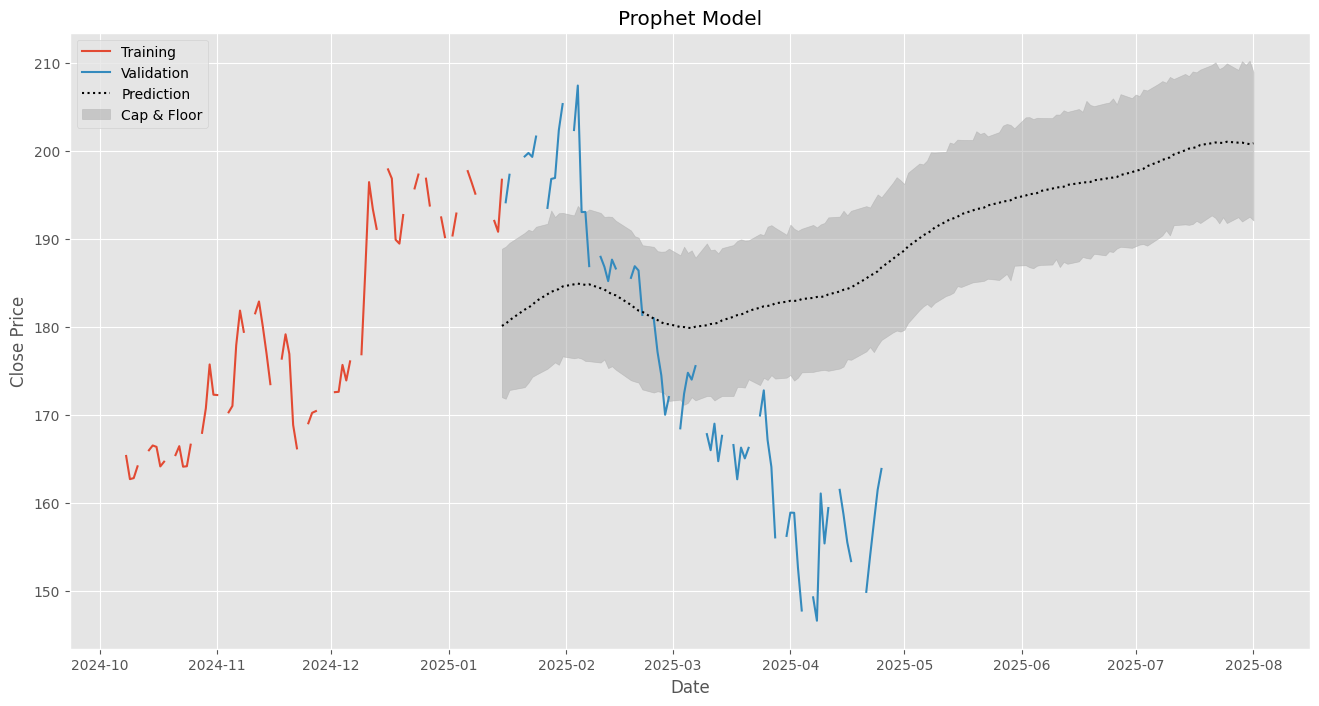

In [39]:
#viz = viz_df.iloc[-400:,:]
fig, ax1 = plt.subplots()
ax1.plot(data_train.iloc[-100:,:].Close)
ax1.plot(data_test.Close)
ax1.plot(predict_df.yhat, color='black', linestyle=':')
ax1.fill_between(predict_df.index, predict_df['yhat_upper'], predict_df['yhat_lower'], alpha=0.5, color='darkgray')
ax1.set_title('Prophet Model')
ax1.set_ylabel('Close Price')
ax1.set_xlabel('Date')
L=ax1.legend(['Training', 'Validation','Prediction', 'Cap & Floor' ]) #get the legend


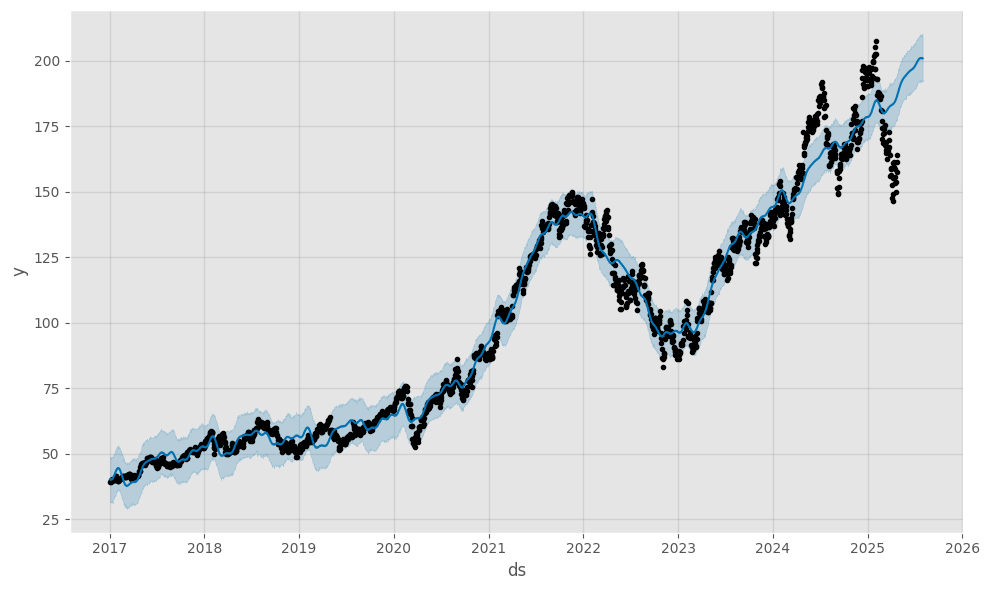

In [40]:
fig1 = model.plot(forecast)

In [42]:
from prophet.plot import plot_plotly
import plotly.offline as py
fig = plot_plotly( model, forecast)
py.iplot(fig)

In [44]:
actual_values = df['y'].iloc[-365:].values  # Last 365 actual values
predicted_values = forecast['yhat'].iloc[-365:].values  # Last 365 predicted values

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_values, predicted_values)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, predicted_values)
print(f"Mean Squared Error (MSE): {mse}")

# Optionally, print Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Absolute Error (MAE): 14.253601638493192
Mean Squared Error (MSE): 304.87095844217913
Root Mean Squared Error (RMSE): 17.46055435666861


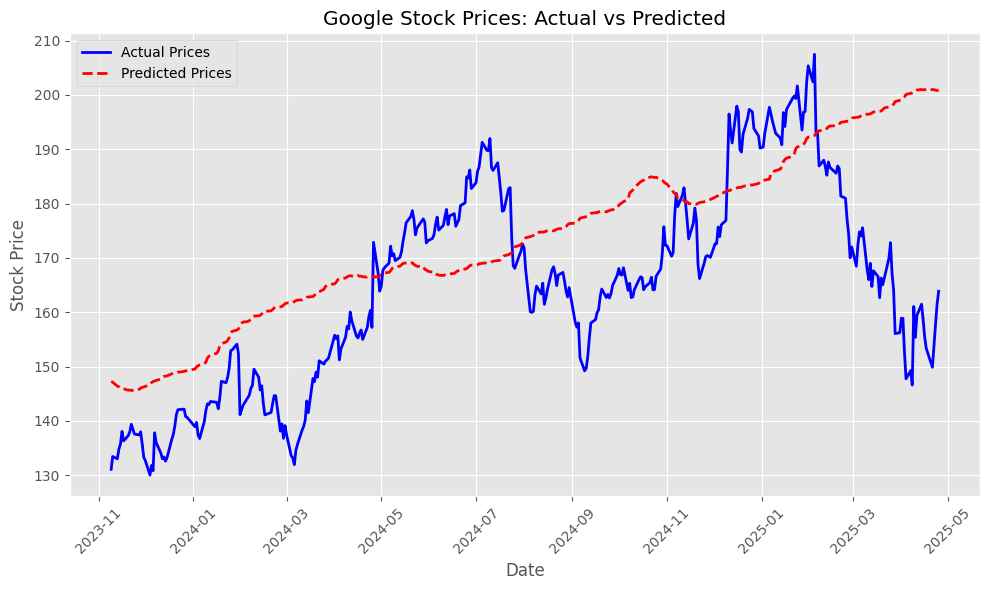

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(df['ds'].iloc[-365:], actual_values, label='Actual Prices', color='blue', linestyle='-', linewidth=2)
plt.plot(df['ds'].iloc[-365:], predicted_values, label='Predicted Prices', color='red', linestyle='--', linewidth=2)
plt.title('Google Stock Prices: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()